In [1]:
import pandas as pd
import spacy

### Load data

In [2]:
data= pd.read_csv('Dataset/dev.csv')
data = data[data['lang']=='en']

### Information Extraction Pipeline

InformationExtractionPipeline as a class to add information from wikipedia page. This class requires an entity extractor function that returns all the entities from a sentence. For a sentence, it will find wikipedia pages based on the extracted entities. And for each enitity, it will add a fixed length of sentences for wiki page to the original sentence. 

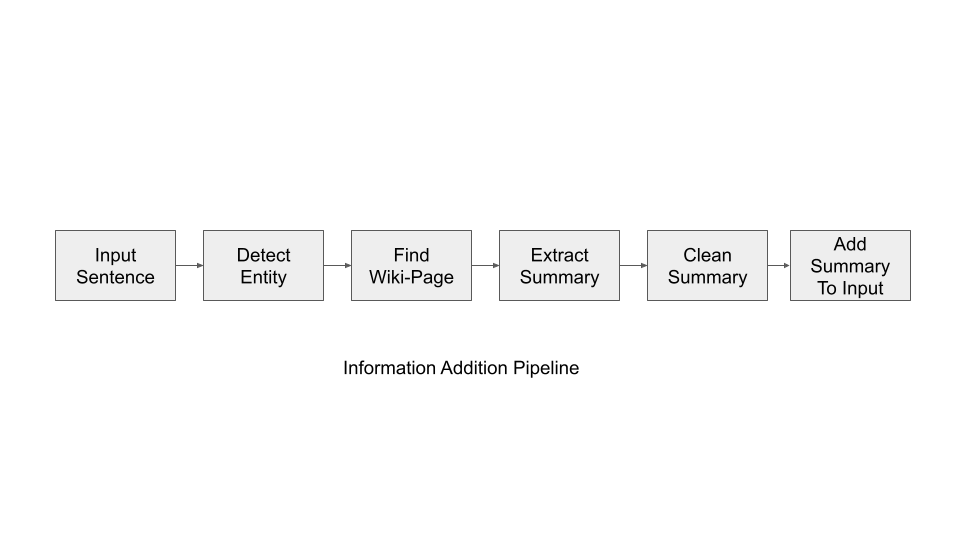

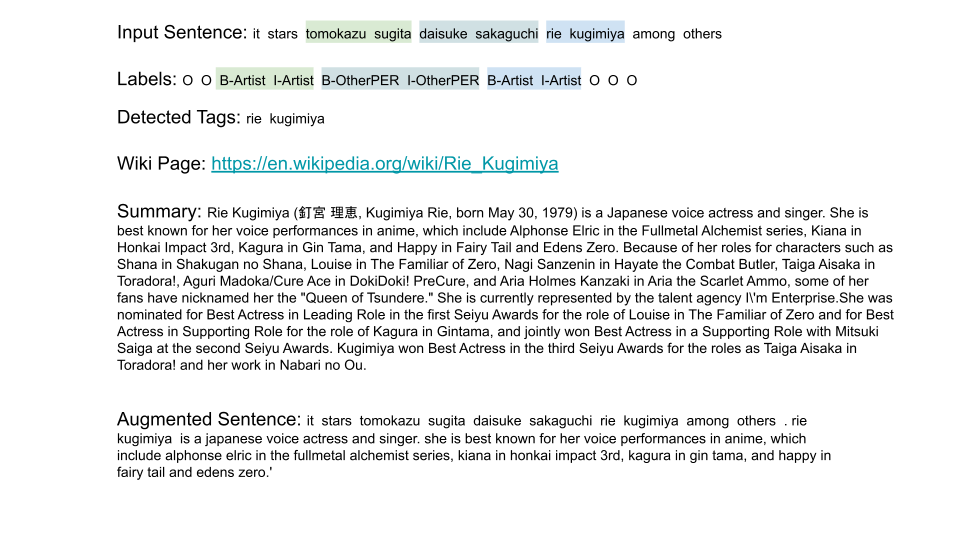

In [3]:
#import the pipeline class


from InformationExtraction import InformationExtractionPipeline


# example spacy extractor function
NER = spacy.load("en_core_web_lg")
def tag_extraction_from_spacy(sen, model = NER):
    
    annotated = model(sen)
    extracted_names = [word.text for word in annotated.ents 
                       if word.label_=='PERSON' or word.label_=='ORG'or word.label_=='GPE']
    
    
    return extracted_names


# example extractor function that uses training labels 
sent_to_tag = dict(zip(data['sent'],data['labels']))
def tag_extraction_from_tags(sent, sent_to_tag=sent_to_tag):

    tags = sent_to_tag[sent]
    sentsWithtags = [(s,t) for s,t in zip(sent.split(),tags.split())]
    entity_list = []
    for i,item in enumerate(sentsWithtags):
        if 'B-' in item[1]:
            j = i
            entity = []
            while j<len(sentsWithtags):
                if sentsWithtags[j][1] =='O':
                    break
                entity.append(sentsWithtags[j][0])
                j+=1
            i = j
         
            entity_list.append(" ".join(entity))
            
    

    return entity_list



In [5]:
tag_extraction_from_spacy("Newton born in New York")

['Newton', 'New York']

In [4]:
#create pipline object:
#param: extractor: an entity extractor function that returns all the entities from a sentence
#param: max_sen: define the number of sentences to be added for each detected entity
#param: lang: define language. needed for wikipedia api
#param: saveJson: whether to save extracted informaton as json file. Saves time if needed to run the pipeline again
#param: loadJson: if you have saved a json file and want to use it
#param: jsonPath: define saved json file path

pipeline = InformationExtractionPipeline(extractor = tag_extraction_from_spacy, max_sen = 2, 
                                         lang = 'en', loadJson = False, jsonPath='wiki-info-dev.json',
                                         saveJson=True)

In [5]:
#call pipline and provide list of sentences as argument

augmented = pipeline(data['sent'].values.tolist())

100%|█████████████████████████████████████████| 870/870 [05:34<00:00,  2.60it/s]


### Info Percentage

In [6]:
data['augmented_sen'] = augmented
temp = data[data['sent']!=data['augmented_sen']]


In [18]:
info_percent = temp.shape[0]/data.shape[0]
print(f"Info Percentage: {info_percent*100:.2f}%")

Info Percentage: 33.91%


### Save Augmented Data

In [19]:
data.to_csv('./Dataset/dev-wiki-spacy.csv',index=False)